In [1]:
import glob

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
awkward_repos = np.array([202413762, 137079949, 202413762, 137079949])
distinct_people = set()

for filename in sorted(glob.glob("/home/jpivarski/storage/data/GHArchive/GHArchive-*-aggregated.h5")):
    print(filename)
    with h5py.File(filename, mode="r") as file:
        actors = file["actor_id"][np.isin(file["repo_id"], awkward_repos)]
        distinct_people.update(actors)
    print(len(distinct_people))

/home/jpivarski/storage/data/GHArchive/GHArchive-2015-aggregated.h5
0
/home/jpivarski/storage/data/GHArchive/GHArchive-2016-aggregated.h5
0
/home/jpivarski/storage/data/GHArchive/GHArchive-2017-aggregated.h5
0
/home/jpivarski/storage/data/GHArchive/GHArchive-2018-aggregated.h5
31
/home/jpivarski/storage/data/GHArchive/GHArchive-2019-aggregated.h5
198
/home/jpivarski/storage/data/GHArchive/GHArchive-2020-aggregated.h5
450
/home/jpivarski/storage/data/GHArchive/GHArchive-2021-aggregated.h5
767
/home/jpivarski/storage/data/GHArchive/GHArchive-2022-aggregated.h5
969
/home/jpivarski/storage/data/GHArchive/GHArchive-2023-aggregated.h5
1120
/home/jpivarski/storage/data/GHArchive/GHArchive-2024-aggregated.h5
1190


In [ ]:
existing = set(tuple(x.rstrip("\n").split("\t")[0:2]) for x in open("distinct_people.txt"))

for line in open("/home/jpivarski/storage/data/GHArchive/actor_id_name.txt"):
    idstr, name = line.rstrip("\n").split("\t")
    if int(idstr) in distinct_people:
        if (idstr, name) not in existing:
            # print(line, end="")
            pass

In [3]:
people_usernames = {}
people_categories = {}

with open("distinct_people.txt") as file:
    for line in file:
        idstr, username, category = line.rstrip("\n").split("\t")
        people_usernames[int(idstr)] = username
        people_categories[int(idstr)] = category

In [4]:
with open("nonhep-usernames.txt", "w") as file:
    for uid in people_usernames:
        if people_categories[uid] != "HEP":
            file.write(people_usernames[uid])
            file.write("\n")

In [5]:
set(people_categories.values())

{'AI',
 'ASTRO',
 'BIOLOGY',
 'CHEMISTRY',
 'CS',
 'DS',
 'ECONOMICS',
 'GEO',
 'HEALTH',
 'HEP',
 'IDK',
 'MATH',
 'MEDICAL',
 'PHYSICS',
 'QUANT',
 'SE'}

`HEP` versus everything else is the main categorization. This definition of HEP includes dark matter searches, neutrino experiments, and nuclear physics. It is as lenient a definition as possible, including everyone who has ever been in HEP, even if they are not now, and students who do not study HEP but were involved in developing HEP projects (e.g. IRIS-HEP fellows). Thus, when we see "non-HEP" in the plot, it really means "non-HEP," interest in Awkward Array that is truly beyond our HEP community.

`PHYSICS` includes anything that touches on physics, including materials science and chemistry, that isn't HEP. It can be merged with the single instance of `ACOUSTIC` and the only two instances of `CHEMISTRY`.

`ASTRO` includes astronomy, astrophysics, cosmology, etc. It includes LSST/Vera Rubin and gamma ray detectors.

`BIOLOGY` is mostly neuroscience, but also bioinformatics and genomics. It can be merged with `MEDICAL` and `HEALTH`.

`GEO` may be its own group, but it's combining things like Earth sciences, climatology, and geosciences.

`SE` (software engineering), `AI` (artificial intelligence), `DS` (data science), `CS` (computer science), and `QUANT` (finance) are hopelessly interchangeable. It was very hard for me to make useful distinctions among them, based on their GitHub info. Nevertheless, I wish I made a separate category for robotics.

There's only one instance of `ECONOMICS` and four of `MATH`. They can be included in the giant group above.

`IDK` is for everyone who could not be classified. It usually meant that they had no repos, or the only repos they had were forks, and that wasn't enough to tell me their interests.

GitHub users who no longer exist (18% of the total) were removed from the sample.

In [29]:
fewer_categories = {x: x for x in (
    "particle physics", "other physics", "astro/cosmology", "biomedical", "geosciences", "computing (CS and industry)", "unknown (or closed account)"
)}

class DictWithUnknown(dict):
    def __missing__(self, key):
        return fewer_categories["unknown (or closed account)"]

people_fewer_categories = DictWithUnknown()

for k, v in people_categories.items():
    if v == "HEP":
        people_fewer_categories[k] = fewer_categories["particle physics"]
    elif v in ("PHYSICS", "ACOUSTIC", "CHEMISTRY"):
        people_fewer_categories[k] = fewer_categories["other physics"]
    elif v == "ASTRO":
        people_fewer_categories[k] = fewer_categories["astro/cosmology"]
    elif v in ("BIOLOGY", "MEDICAL", "HEALTH"):
        people_fewer_categories[k] = fewer_categories["biomedical"]
    elif v == "GEO":
        people_fewer_categories[k] = fewer_categories["geosciences"]
    elif v in ("SE", "AI", "DS", "CS", "QUANT", "ECONOMICS", "MATH"):
        people_fewer_categories[k] = fewer_categories["computing (CS and industry)"]
    elif v == "IDK":
        people_fewer_categories[k] = fewer_categories["unknown (or closed account)"]
    else:
        raise AssertionError(v)

In [7]:
dfs = []

for filename in sorted(
    glob.glob(
        "/home/jpivarski/storage/data/GHArchive/GHArchive-[0-9][0-9][0-9][0-9].h5"
    )
):
    print(filename)
    with h5py.File(filename, mode="r") as file:
        is_awkward = np.isin(file["repo_id"], awkward_repos)
        dfs.append(
            pd.DataFrame(
                {
                    "timestamp": file["timestamp"][is_awkward],
                    "actor_id": file["actor_id"][is_awkward],
                    "event_type_id": file["event_type_id"][is_awkward],
                }
            )
        )

/home/jpivarski/storage/data/GHArchive/GHArchive-2015.h5
/home/jpivarski/storage/data/GHArchive/GHArchive-2016.h5
/home/jpivarski/storage/data/GHArchive/GHArchive-2017.h5
/home/jpivarski/storage/data/GHArchive/GHArchive-2018.h5
/home/jpivarski/storage/data/GHArchive/GHArchive-2019.h5
/home/jpivarski/storage/data/GHArchive/GHArchive-2020.h5
/home/jpivarski/storage/data/GHArchive/GHArchive-2021.h5
/home/jpivarski/storage/data/GHArchive/GHArchive-2022.h5
/home/jpivarski/storage/data/GHArchive/GHArchive-2023.h5
/home/jpivarski/storage/data/GHArchive/GHArchive-2024.h5


In [30]:
df = pd.concat(dfs, ignore_index=True)
df

,timestamp,actor_id,event_type_id
0,1528812036,1852447,2
1,1528812037,1852447,2
2,1528813392,1852447,17
3,1528814324,1852447,17
4,1528815027,1852447,17
...,...,...,...
36617,1723735378,1852447,17
36618,1723735806,4616906,2
36619,1723735808,4616906,14
36620,1723737406,4616906,10


In [31]:
df["category"] = df["actor_id"].map(people_fewer_categories)

In [32]:
set(df["category"])

{'astro/cosmology',
 'biomedical',
 'computing (CS and industry)',
 'geosciences',
 'other physics',
 'particle physics',
 'unknown (or closed account)'}

In [33]:
# https://docs.github.com/en/webhooks-and-events/events/github-event-types

event_type_id = {
     1: "CommitCommentEvent",                # A commit comment is created.
     2: "CreateEvent",                       # A Git branch or tag is created.
     3: "DeleteEvent",                       # A Git branch or tag is deleted.
     4: "DownloadEvent",                     # ???
     5: "FollowEvent",                       # Same as WatchEvent???
     6: "ForkApplyEvent",                    # ???
     7: "ForkEvent",                         # A user forks a repository. 
     8: "GistEvent",                         # ???
     9: "GollumEvent",                       # A wiki page is created or updated.
    10: "IssueCommentEvent",                 # Activity related to an issue or pull request comment.
    11: "IssuesEvent",                       # Activity related to an issue.
    12: "MemberEvent",                       # Activity related to repository collaborators.
    13: "PublicEvent",                       # When a private repository is made public.
    14: "PullRequestEvent",                  # Activity related to pull requests.
    15: "PullRequestReviewCommentEvent",     # Activity related to pull request review comments in the pull request's unified diff.
    16: "PullRequestReviewEvent",            # Activity related to pull request reviews.
    17: "PushEvent",                         # One or more commits are pushed to a repository branch or tag.
    18: "ReleaseEvent",                      # Activity related to a release.
    19: "TeamAddEvent",                      # ???
    20: "WatchEvent",                        # When someone stars a repository.
}

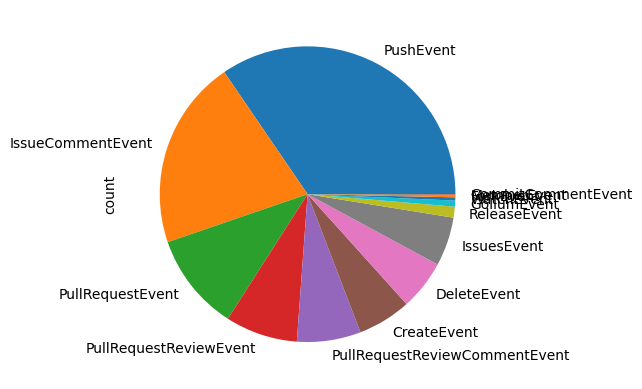

In [34]:
df["event_type_id"][df["category"] == "particle physics"].map(event_type_id).value_counts().plot.pie();

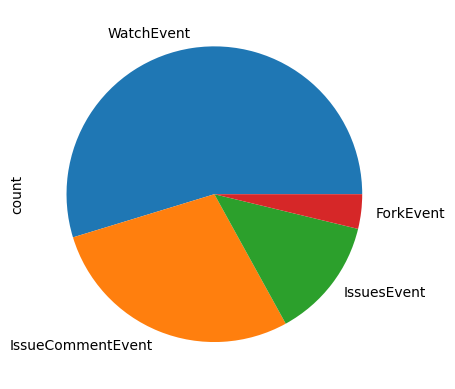

In [35]:
df["event_type_id"][df["category"] == "other physics"].map(event_type_id).value_counts().plot.pie();

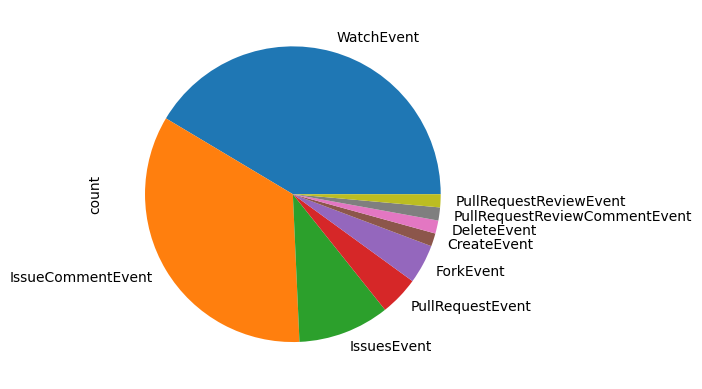

In [36]:
df["event_type_id"][df["category"] == "astro/cosmology"].map(event_type_id).value_counts().plot.pie();

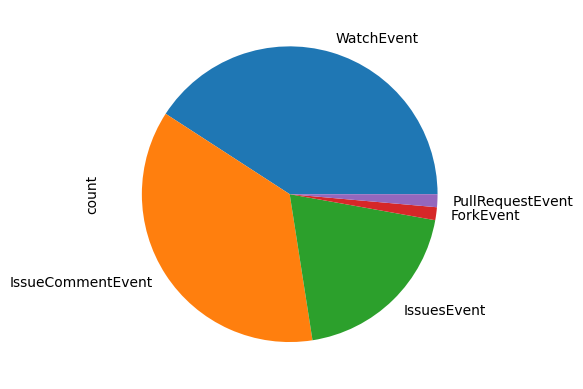

In [37]:
df["event_type_id"][df["category"] == "biomedical"].map(event_type_id).value_counts().plot.pie();

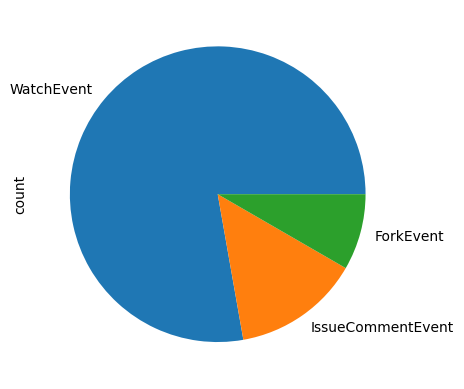

In [38]:
df["event_type_id"][df["category"] == "geosciences"].map(event_type_id).value_counts().plot.pie();

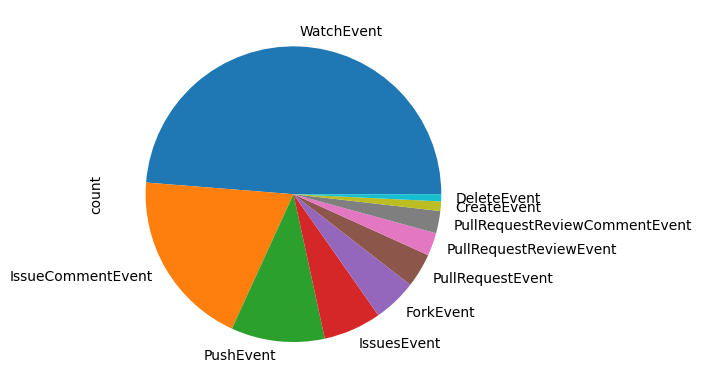

In [39]:
df["event_type_id"][df["category"] == "computing (CS and industry)"].map(event_type_id).value_counts().plot.pie();

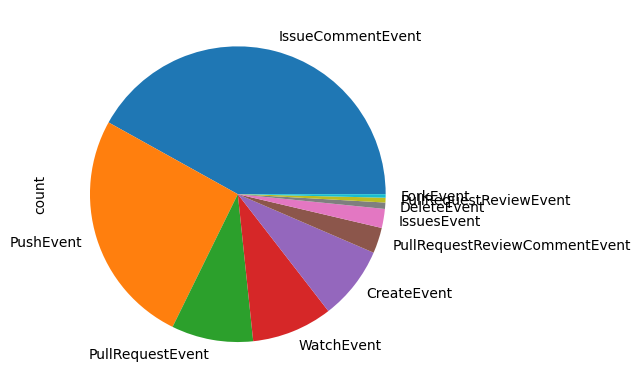

In [40]:
df["event_type_id"][df["category"] == "unknown (or closed account)"].map(event_type_id).value_counts().plot.pie();

In [41]:
fewer_event_types = {
     1: "comment",
     2: "",
     3: "",
     4: "",
     5: "star",
     6: "contribute",
     7: "star",
     8: "",
     9: "",
    10: "comment",
    11: "contribute",
    12: "",
    13: "",
    14: "contribute",
    15: "comment",
    16: "comment",
    17: "contribute",
    18: "",
    19: "",
    20: "star",
}

In [42]:
df["event_type"] = df["event_type_id"].map(fewer_event_types)

In [43]:
set(df["event_type"])

{'', 'comment', 'contribute', 'star'}

In [44]:
df.sort_values("timestamp", inplace=True)

In [45]:
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")

In [46]:
df.set_index("timestamp", inplace=True)

In [47]:
df

,actor_id,event_type_id,category,event_type
timestamp,,,,
2018-06-12 14:00:36,1852447,2,particle physics,
2018-06-12 14:00:37,1852447,2,particle physics,
2018-06-12 14:23:12,1852447,17,particle physics,contribute
2018-06-12 14:38:44,1852447,17,particle physics,contribute
2018-06-12 14:50:27,1852447,17,particle physics,contribute
...,...,...,...,...
2024-08-15 15:22:58,1852447,17,particle physics,contribute
2024-08-15 15:30:06,4616906,2,particle physics,
2024-08-15 15:30:08,4616906,14,particle physics,contribute


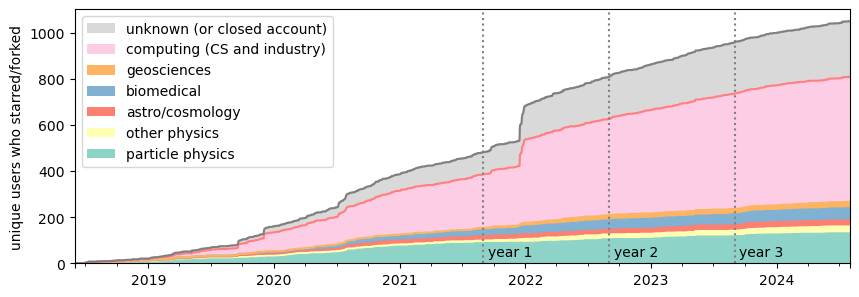

In [56]:
fig, ax = plt.subplots(figsize=(10, 3.3))

cumulative = pd.DataFrame({}, index=pd.DatetimeIndex(pd.date_range(start="2018-06-01", end="2024-08-01", freq="D")))

for category in ["particle physics", "other physics", "astro/cosmology", "biomedical", "geosciences", "computing (CS and industry)", "unknown (or closed account)"]:
    selected = df[(df["event_type"] == "star") & (df["category"] == category)]
    cumulative[category] = selected["actor_id"].drop_duplicates(keep="first").resample("D").count().cumsum()

cumulative.ffill().fillna(0).plot.area(ax=ax, stacked=True, color=["#8dd3c7", "#ffffb3", "#fb8072", "#80b1d3", "#fdb462", "#fccde4", "#d9d9d9"])

for collection in ax.collections:
    collection.set_edgecolor("black")
    collection.set_linewidth(0)

cumulative.drop("unknown (or closed account)", axis=1).ffill().fillna(0).sum(axis=1).plot.line(color="#ff8080")
cumulative.ffill().fillna(0).sum(axis=1).plot.line(color="gray")

ax.axvline("2021-09-01", ls=":", color="gray")
ax.axvline("2022-09-01", ls=":", color="gray")
ax.axvline("2023-09-01", ls=":", color="gray")
ax.text("2021-09-15", 50, "year 1", ha="left", va="center")
ax.text("2022-09-15", 50, "year 2", ha="left", va="center")
ax.text("2023-09-15", 50, "year 3", ha="left", va="center")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc="upper left")

ax.set_ylabel("unique users who starred/forked")
fig.savefig("hep-vs-other-star.pdf")
fig.savefig("hep-vs-other-star.svg")

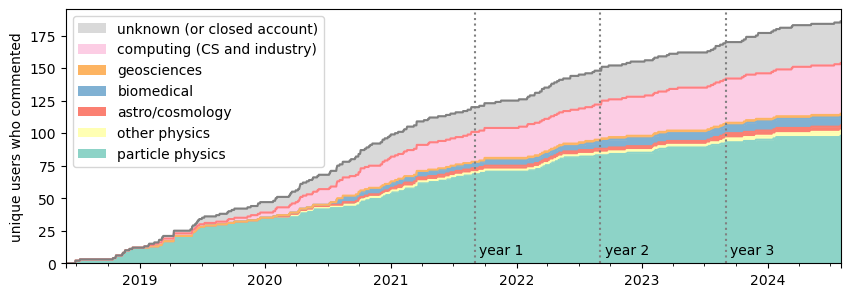

In [57]:
fig, ax = plt.subplots(figsize=(10, 3.3))

cumulative = pd.DataFrame({}, index=pd.DatetimeIndex(pd.date_range(start="2018-06-01", end="2024-08-01", freq="D")))

for category in ["particle physics", "other physics", "astro/cosmology", "biomedical", "geosciences", "computing (CS and industry)", "unknown (or closed account)"]:
    selected = df[(df["event_type"] == "comment") & (df["category"] == category)]
    cumulative[category] = selected["actor_id"].drop_duplicates(keep="first").resample("D").count().cumsum()

cumulative.ffill().fillna(0).plot.area(ax=ax, stacked=True, color=["#8dd3c7", "#ffffb3", "#fb8072", "#80b1d3", "#fdb462", "#fccde4", "#d9d9d9"])

for collection in ax.collections:
    collection.set_edgecolor("black")
    collection.set_linewidth(0)

cumulative.drop("unknown (or closed account)", axis=1).ffill().fillna(0).sum(axis=1).plot.line(color="#ff8080")
cumulative.ffill().fillna(0).sum(axis=1).plot.line(color="gray")

ax.axvline("2021-09-01", ls=":", color="gray")
ax.axvline("2022-09-01", ls=":", color="gray")
ax.axvline("2023-09-01", ls=":", color="gray")
ax.text("2021-09-15", 10, "year 1", ha="left", va="center")
ax.text("2022-09-15", 10, "year 2", ha="left", va="center")
ax.text("2023-09-15", 10, "year 3", ha="left", va="center")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc="upper left")

ax.set_ylabel("unique users who commented")
fig.savefig("hep-vs-other-comment.pdf")
fig.savefig("hep-vs-other-comment.svg")

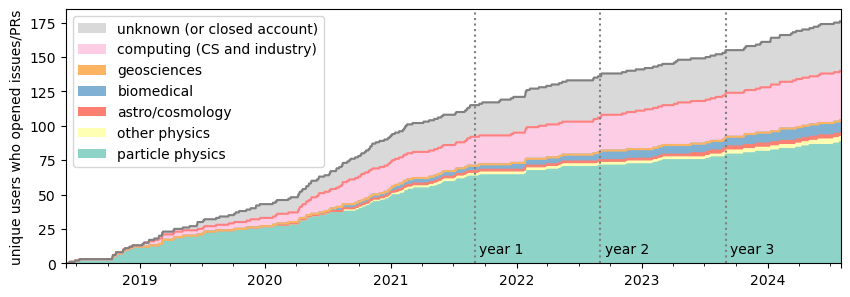

In [58]:
fig, ax = plt.subplots(figsize=(10, 3.3))

cumulative = pd.DataFrame({}, index=pd.DatetimeIndex(pd.date_range(start="2018-06-01", end="2024-08-01", freq="D")))

for category in ["particle physics", "other physics", "astro/cosmology", "biomedical", "geosciences", "computing (CS and industry)", "unknown (or closed account)"]:
    selected = df[(df["event_type"] == "contribute") & (df["category"] == category)]
    cumulative[category] = selected["actor_id"].drop_duplicates(keep="first").resample("D").count().cumsum()

cumulative.ffill().fillna(0).plot.area(ax=ax, stacked=True, color=["#8dd3c7", "#ffffb3", "#fb8072", "#80b1d3", "#fdb462", "#fccde4", "#d9d9d9"])

for collection in ax.collections:
    collection.set_edgecolor("black")
    collection.set_linewidth(0)

cumulative.drop("unknown (or closed account)", axis=1).ffill().fillna(0).sum(axis=1).plot.line(color="#ff8080")
cumulative.ffill().fillna(0).sum(axis=1).plot.line(color="gray")

ax.axvline("2021-09-01", ls=":", color="gray")
ax.axvline("2022-09-01", ls=":", color="gray")
ax.axvline("2023-09-01", ls=":", color="gray")
ax.text("2021-09-15", 10, "year 1", ha="left", va="center")
ax.text("2022-09-15", 10, "year 2", ha="left", va="center")
ax.text("2023-09-15", 10, "year 3", ha="left", va="center")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc="upper left")

ax.set_ylabel("unique users who opened issues/PRs")
fig.savefig("hep-vs-other-contribute.pdf")
fig.savefig("hep-vs-other-contribute.svg")